In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-16_20-01_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2018-06-01 12:50:30,GC,SELL,2.0,1301.30,1,ENTRY,4.84,0.00,80000.00
2018-06-01 12:50:30,GC,SELL,0.7,1301.30,2,ENTRY,3.29,0.00,80000.00
2018-06-01 14:38:30,GC,BUY,0.7,1296.90,4,STOP-LOSS,3.29,301.42,81171.74
2018-06-01 14:38:30,GC,BUY,2.0,1296.90,3,STOP-LOSS,4.84,870.32,80870.32
2018-06-01 15:35:30,NQ,BUY,0.9,7029.50,6,ENTRY,4.23,0.00,81171.74
...,...,...,...,...,...,...,...,...,...
2019-12-30 10:48:30,GC,SELL,0.3,1515.30,6542,STOP-LOSS,1.41,-110.82,566454.06
2019-12-30 16:13:30,NQ,SELL,16.0,8707.25,6543,ENTRY,33.60,0.00,566454.06
2019-12-30 16:13:30,NQ,SELL,0.8,8707.25,6544,ENTRY,3.76,0.00,566454.06


In [5]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES       118131.98
GC        61043.18
NQ       177846.16
YM       129862.02
total    486883.34
Name: realizedPNL, dtype: float64

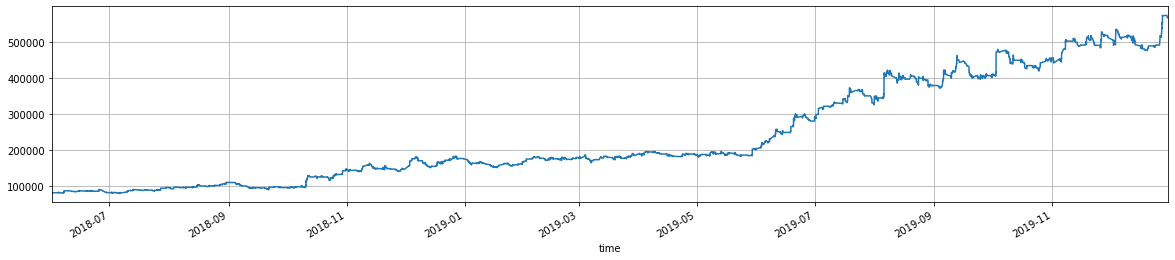

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

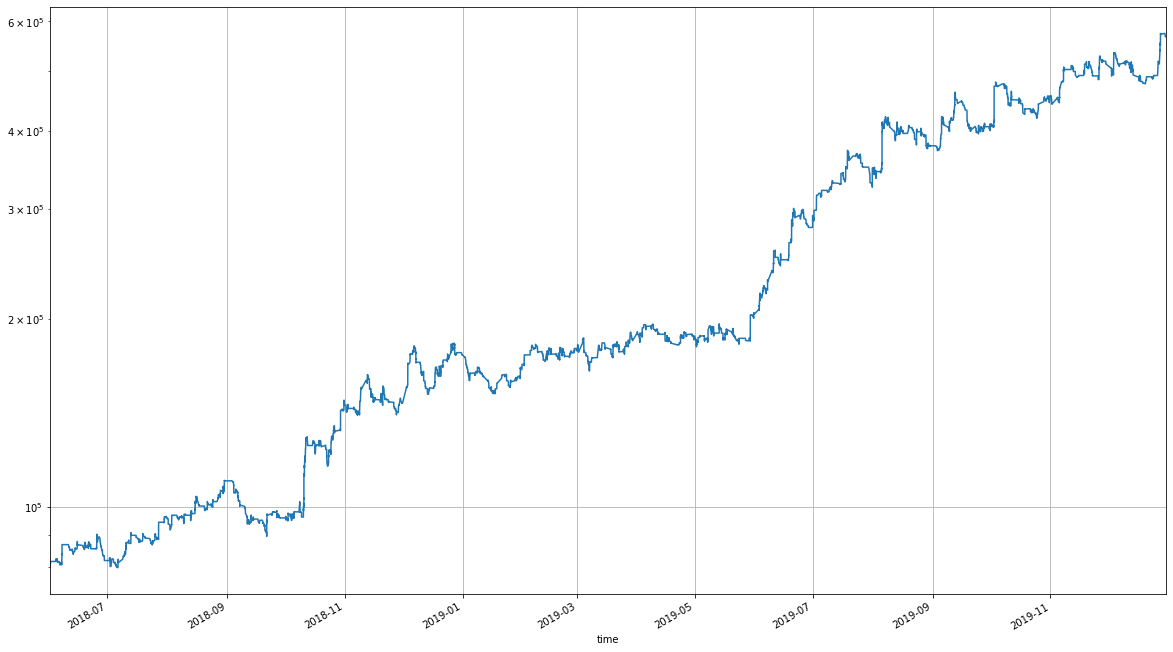

In [7]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [9]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,ES,NQ,YM,GC
time,,,,
2018-06-30,1.238095,7.428571,2.100000,3.523810
2018-07-31,1.181818,5.181818,1.454545,2.727273
2018-08-31,0.956522,6.173913,1.565217,4.434783
2018-09-30,1.300000,7.600000,1.400000,4.300000
2018-10-31,2.782609,12.782609,3.478261,3.739130
2018-11-30,1.909091,11.727273,2.409091,2.909091
2018-12-31,2.952381,13.238095,3.571429,2.952381
2019-01-31,1.565217,8.695652,2.434783,2.956522
2019-02-28,0.800000,6.800000,1.700000,2.350000


In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     624
 GC    1550
 NQ    3504
 YM     854
 Name: action, dtype: int64, 6532)

In [11]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.514563
 GC    3.762136
 NQ    8.504854
 YM    2.072816
 Name: action, dtype: float64, 15.854368932038835)

In [12]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES        3893.02
GC       15674.82
NQ       21751.34
YM        5375.98
total    46695.16
Name: commission, dtype: float64

In [13]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES        3.3
GC       25.7
NQ       12.2
YM        4.1
total     9.6
dtype: float64

In [14]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'contracts_per_position', 'number_of_positions', 
                                'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['contracts_per_position'] = round(d.amount.sum() / d.amount.count(), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,contracts_per_position,number_of_positions,number_of_contracts
GC,0.38,17.04,466.87,-262.46,1.78,14.69,3.98,775.0,3085.5
NQ,0.40,29.32,454.64,-256.39,1.77,28.02,2.68,1752.0,4702.1
YM,0.45,125.42,757.25,-385.94,1.96,128.50,2.73,427.0,1167.7
ES,0.44,121.75,995.80,-562.51,1.77,123.15,2.72,312.0,847.3
total,0.41,47.80,556.65,-301.33,1.85,50.44,3.00,3266.0,9802.6


In [15]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

GC       0.148421
NQ       0.270000
YM       0.737778
ES       0.497273
total    0.410976
dtype: float64

In [16]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.00,4686.96,2009.76,0.00,1674.18
2018-06-04,0.00,0.00,1017.28,0.00,254.32
2018-06-05,0.00,-3737.04,2701.92,-129.12,-291.06
2018-06-06,0.00,-2441.04,-1669.12,0.00,-1027.54
2018-06-07,11366.40,-3197.04,3302.88,13730.88,6300.78
...,...,...,...,...,...
2019-12-24,0.00,25758.96,0.00,0.00,6439.74
2019-12-25,0.00,0.00,0.00,0.00,0.00
2019-12-26,0.00,104611.44,0.00,0.00,26152.86


In [17]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.000000,0.014647,0.006281,0.000000,0.020927
2018-06-04,0.000000,0.000000,0.003114,0.000000,0.003114
2018-06-05,0.000000,-0.011403,0.008245,-0.000394,-0.003553
2018-06-06,0.000000,-0.007475,-0.005111,0.000000,-0.012587
2018-06-07,0.035251,-0.009915,0.010243,0.042584,0.078164
...,...,...,...,...,...
2019-12-24,0.000000,0.013290,0.000000,0.000000,0.013290
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.053263,0.000000,0.000000,0.053263


In [18]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

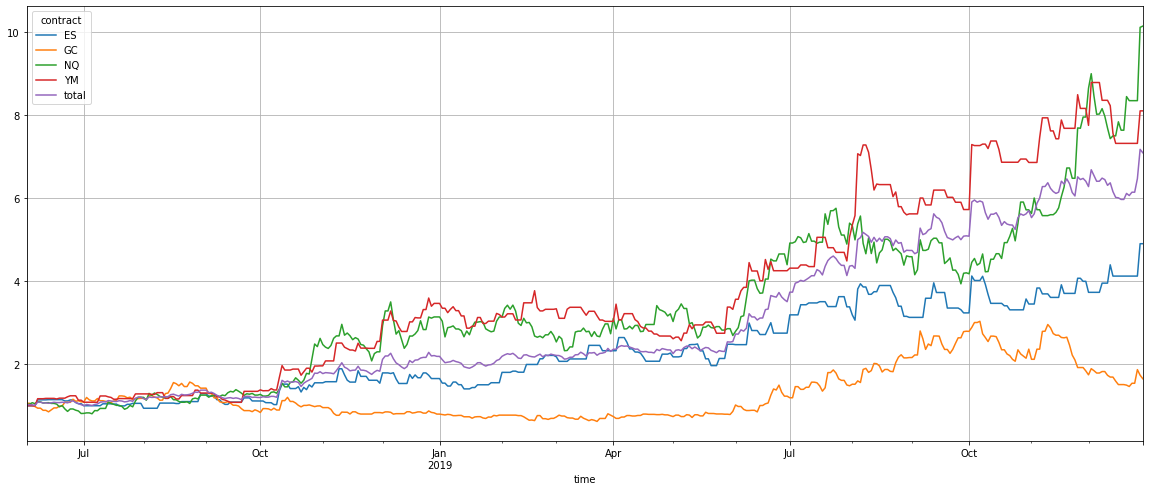

In [19]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [20]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.063239,0.208535,0.483369,0.651189
GC,-0.063239,1.000000,0.038567,0.010646,0.442685
NQ,0.208535,0.038567,1.000000,0.233446,0.630695
YM,0.483369,0.010646,0.233446,1.000000,0.683779
total,0.651189,0.442685,0.630695,0.683779,1.000000


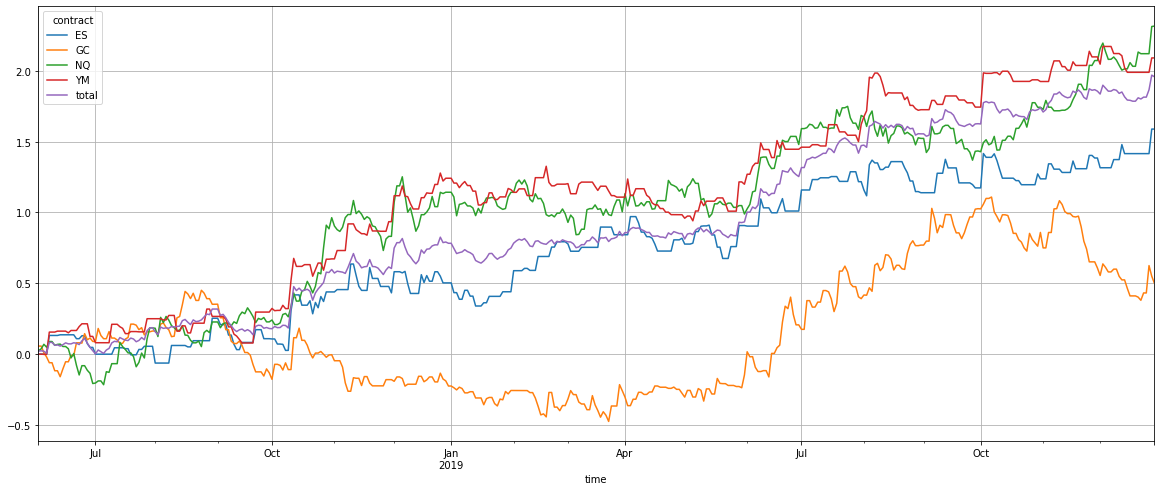

In [21]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

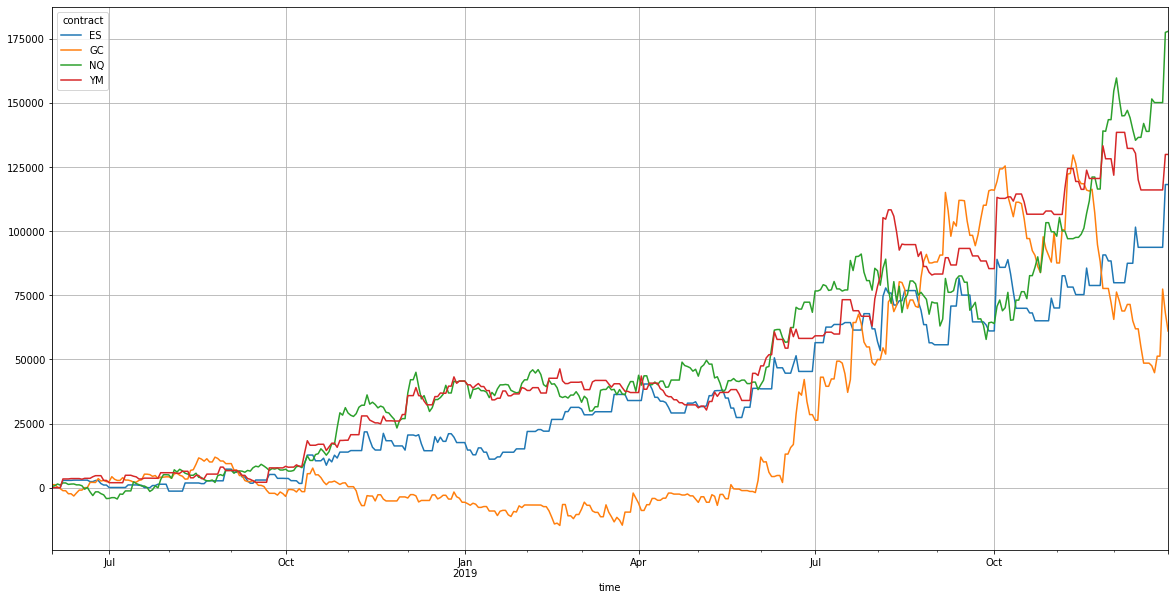

In [22]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [23]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,1.642869,0.357734,3.122929,2.593400,2.312454
Cumulative returns,3.898467,0.648699,9.134742,7.094827,6.086042
Annual volatility,0.800563,0.880482,0.866858,0.765667,0.499914
Sharpe ratio,1.587553,0.763219,2.056768,2.029725,2.640431
Calmar ratio,6.406862,0.592382,9.304874,8.112798,13.820490
Stability,0.942334,0.337853,0.901498,0.927001,0.959756
Max drawdown,-0.256423,-0.603889,-0.335623,-0.319668,-0.167321
Omega ratio,1.541708,1.164946,1.462954,1.719240,1.672018
Sortino ratio,3.453893,1.442476,3.726789,4.687701,5.889775
Skew,2.329783,1.636383,0.905352,2.391395,1.955643


In [24]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.347129,0.155065,0.525276,0.448225,2.312454
Cumulative returns,0.627699,0.265775,0.994161,0.832122,6.086042
Annual volatility,0.200141,0.220121,0.216714,0.191417,0.499914
Sharpe ratio,1.587553,0.763219,2.056768,2.029725,2.640431
Calmar ratio,5.167480,0.839967,5.951627,5.213116,13.820490
Stability,0.958682,0.504480,0.928983,0.939577,0.959756
Max drawdown,-0.067176,-0.184608,-0.088258,-0.085980,-0.167321
Omega ratio,1.541708,1.164946,1.462954,1.719240,1.672018
Sortino ratio,3.453893,1.442476,3.726789,4.687701,5.889775
Skew,2.329783,1.636383,0.905352,2.391395,1.955643


In [25]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.41,2.61,-4.76,3.52,2.44
2018-07-31,0.28,2.16,11.10,3.46,17.67
2018-08-31,5.64,5.39,1.55,0.73,14.04
2018-09-30,-3.29,-11.08,0.16,1.31,-12.81
2018-10-31,9.96,4.14,21.50,10.79,51.67
2018-11-30,0.63,-3.95,-2.76,7.34,0.70
2018-12-31,2.42,-0.96,9.67,8.68,19.49
2019-01-31,-1.36,-0.63,0.46,-1.75,-3.37
2019-02-28,9.63,-2.15,-3.44,1.35,5.16


In [26]:
monthly_returns.total.mean(), monthly_returns.total.median()

(11.693157894736842, 8.649999999999999)

In [27]:
monthly_returns.sort_values('total', ascending = False).total

time
2018-10-31    51.67
2019-06-30    37.71
2019-07-31    24.42
2018-12-31    19.49
2018-07-31    17.67
2018-08-31    14.04
2019-11-30    12.41
2019-10-31    11.93
2019-12-31    10.70
2019-08-31     8.65
2019-05-31     8.59
2019-09-30     7.43
2019-02-28     5.16
2019-03-31     3.77
2018-06-30     2.44
2019-04-30     1.57
2018-11-30     0.70
2019-01-31    -3.37
2018-09-30   -12.81
Name: total, dtype: float64

In [28]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        63.0
GC        27.0
NQ        99.0
YM        83.0
total    609.0
dtype: float64

In [29]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:45:30,YM,BUY,26063.00,27457.20
2019-10-02 21:00:00,ES,BUY,2893.75,26566.40
2019-12-27 15:12:00,NQ,SELL,8829.25,25701.20
2019-12-26 17:19:00,GC,SELL,1513.70,25362.56
2019-12-27 21:50:30,ES,SELL,3235.50,23083.00
...,...,...,...,...
2019-12-13 16:30:30,YM,SELL,28180.00,-6921.20
2019-12-30 10:48:30,GC,SELL,1515.30,-6931.96
2019-12-12 14:03:00,YM,SELL,27873.00,-6944.60


In [30]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,27892.64,3436.16,6705.62,27761.76,65796.18
2019-12-27,24464.86,-9312.86,27348.74,13833.84,56334.58
2019-08-05,21130.42,4622.24,6620.76,22972.72,55346.14
2019-09-05,0.00,24408.54,15825.86,6364.12,46598.52
2019-11-26,11898.21,-10494.70,22632.40,12750.40,36786.31
...,...,...,...,...,...
2019-12-13,-7867.60,0.00,1149.60,-10302.08,-17020.08
2019-11-22,0.00,-12371.88,-4672.70,0.00,-17044.58
2019-08-28,-7079.58,-3340.18,-5795.76,-2276.28,-18491.80


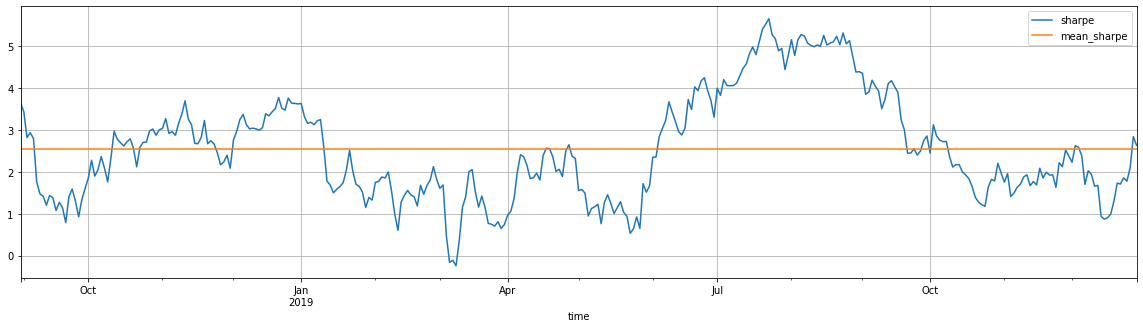

In [31]:
plot_rolling_sharpe(returns.total, 3)

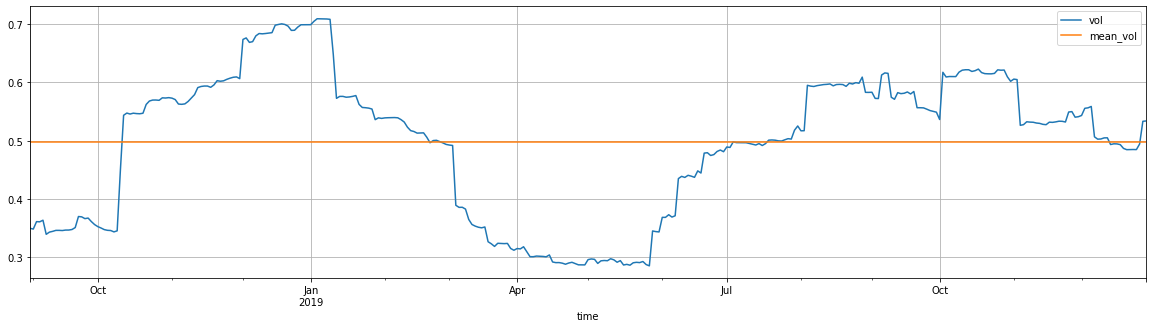

In [32]:
plot_rolling_vol(returns.total, 3)